# Packages and Global variables

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import itertools
from collections import defaultdict
import time
from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision import datasets, transforms, utils
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import snntorch.spikeplot as splt
import math

torch.manual_seed(42)
np.random.seed(42)

#print(torch.cuda.is_available())

In [2]:
#data_path='/data/mnist'
data_path = '\\Users\\liamh\\OneDrive - University of Strathclyde\\University'
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Training Parameters
batch_size=128

# Network Architecture
num_hidden = 350
num_outputs = 10
num_steps = 25

# Convolutional layer parameters 
conv_kernel_size = 3
conv_stride_length = 1 
conv_padding_size = 1
mp_kernel_size = 3 
mp_stride_length = 2 
mp_padding_size = 0

# Temporal Dynamics
time_step = 1e-3
tau_mem = 2e-2
beta = float(np.exp(-time_step/tau_mem))

# Loss Function
loss_fn = nn.MSELoss()

# Functions

In [3]:
def load_in_data(res, ratio = 1):
    transform = transforms.Compose([
        transforms.Resize((res, res)), #Resize images to 28*28
        transforms.Grayscale(), # Make sure image is grayscale
        transforms.ToTensor()]) # change each image array to a tensor which automatically scales inputs to [0,1]

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # Download training set and apply transformations. 
    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform) # same for test set

    train_len = int(len(mnist_train)/ratio)
    dummy_len = len(mnist_train) - train_len
    train_dataset, _ = random_split(mnist_train, (train_len, dummy_len), generator=torch.Generator().manual_seed(42))
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Load the data into the DataLoader so it's passed through the model, shuffled in batches. 
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    return train_loader, test_loader

def output_formula(input_size, filter_size, padding, stride):
    formula = math.floor(((((input_size - filter_size + 2*padding)/stride) + 1)))
    
    return formula 

def all_output_sizes(res, conv_filter = 3, conv_padding = 1, conv_stride = 1, mp_filter = 3, mp_padding = 0, mp_stride = 2):
    
    conv1 = output_formula(res, conv_filter, conv_padding, conv_stride)   # Output size from applying conv1 to input 
    mp1 = output_formula(conv1, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 1 to conv1 
    
    conv2 = output_formula(mp1, conv_filter, conv_padding, conv_stride)   # Output size from applying conv2 to max pooling 1
    conv3 = output_formula(conv2, conv_filter, conv_padding, conv_stride) # Output size from applying conv3 to conv 2
    mp2 = output_formula(conv3, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 2 to conv3
    
    conv4 = output_formula(mp2, conv_filter, conv_padding, conv_stride)   # Output size from applying conv 4 to max pooling 2
    conv5 = output_formula(conv4, conv_filter, conv_padding, conv_stride) # Output size from applying conv5 to conv 4
    mp3 = output_formula(conv5, mp_filter, mp_padding, mp_stride)         # Output size from applying max pooling 3 to conv 5
    
    outputs_I_need = [mp1, conv2, mp2, conv4, mp3]
    
    return outputs_I_need

def plot_training_history(history, res, loss_upper = 1.05, acc_lower = -0.05, acc_higher = 105):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    
    ax1.plot(history['avg_train_loss'], label='train loss',marker = 'o')
    ax1.plot(history['avg_valid_loss'], label='validation loss',marker = 'o')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, loss_upper])
    ax1.legend()
    ax1.set_ylabel('Loss',fontsize = 16)
    ax1.set_xlabel('Epoch',fontsize = 16)
    
    ax2.plot(history['train_accuracy'], label='train accuracy',marker = 'o')
    ax2.plot(history['valid_accuracy'], label='validation accuracy',marker = 'o')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([acc_lower, acc_higher])

    ax2.legend()

    ax2.set_ylabel('Accuracy',fontsize = 16)
    ax2.yaxis.set_major_formatter(PercentFormatter(100))
    ax2.set_xlabel('Epoch',fontsize = 16)
    fig.suptitle(f'Training history ({res}*{res})',fontsize = 20)
    plt.show()

def store_best_results(history):
    # Want to take the last entry from each output(best results) and store them all in a Dataframe
    placeholder = []
    placeholder.append(history['avg_train_loss'][-1])
    placeholder.append(history['train_accuracy'][-1])
    placeholder.append(history['avg_valid_loss'][-1])
    placeholder.append(history['valid_accuracy'][-1])
    
    return placeholder

def put_results_in_df(output):
    df = pd.DataFrame()
    df['avg_train_loss'] = output['avg_train_loss']
    df['train_accuracy'] = output['train_accuracy']
    df['avg_valid_loss'] = output['avg_valid_loss']
    df['valid_accuracy'] = output['valid_accuracy']
    
    return df

# Spiking CNN and training Loop

In [5]:
# Define Network
class Latency_LIF_Snn_Net(nn.Module):
    def __init__(self,res,spike_grad):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(res*res, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states + output spike at t=0
        spk1, mem1 = self.lif1.init_leaky(batch_size, num_hidden)
        spk2, mem2 = self.lif2.init_leaky(batch_size, num_hidden)
        spk3, mem3 = self.lif3.init_leaky(batch_size, num_outputs)

        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1,  mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [6]:
def train_rate_spiking_mse_model(resolution, train_loader, valid_loader, model, epochs ,device = device, verbose = True):
    start_time = time.time()
    print('Starting Training')
    history = defaultdict(list)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999)) # Just an Adam Optimiser
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.5)
    
    # Training variables
    train_size = len(train_loader.dataset)
    train_num_batches = len(train_loader)
    
    # validation variables
    valid_size = len(valid_loader.dataset)
    valid_num_batches = len(valid_loader)
    
    
    for t in range(epochs):
        
        avg_train_loss = 0
        correct = 0
        avg_valid_loss, valid_correct = 0, 0
        model.train()
        for batch, (data_it, targets_it) in enumerate(train_loader):
            data_it = data_it.to(device)
            targets_it = targets_it.to(device)

            optimizer.zero_grad()
            
            # Compute prediction and loss
            spike_data = spikegen.latency(data_it, num_steps=num_steps,tau = 5, threshold=0.01, normalize=True, linear=True)
            spk_targets_it = torch.clamp(spikegen.to_one_hot(targets_it, 10) * 1.05, min=0.05)
            
            spk_rec, mem_rec = model(spike_data.view(num_steps,batch_size, -1)) 
            
            # Sum loss over time steps: BPTT
            loss = torch.zeros((1), dtype=dtype, device=device)   # creates a 1D tensor to store total loss over time. 
            for step in range(num_steps):
                loss += loss_fn(mem_rec[step], spk_targets_it) # Loss at each time step is added to give total loss.

            avg_train_loss += loss
            
            _, predicted = spk_rec.sum(dim=0).max(1) 
            correct += (predicted == targets_it).type(torch.float).sum().item()

            # Backpropagation
            loss.backward()
            optimizer.step()

        avg_train_loss /= train_num_batches
        accuracy = correct / train_size * 100      
        history['avg_train_loss'].append(avg_train_loss.item())
        history['train_accuracy'].append(accuracy)
        
        if verbose == True: 
            print(f"Epoch {t+1} of {epochs}")
            print('-' * 15)
            print(f"Training Results, Epoch {t+1}:\n Accuracy: {(accuracy):>0.1f}%, Avg loss: {avg_train_loss.item():>8f} \n")

              ###################### VALIDATION LOOP ##############################
        model.eval()
        with torch.no_grad():
            for valid_data_it, valid_targets_it in valid_loader:
                valid_data_it = valid_data_it.to(device)
                valid_targets_it = valid_targets_it.to(device)
                
                valid_spike_data = spikegen.latency(valid_data_it, num_steps=num_steps,tau = 5, threshold=0.01, normalize=True, linear=True)
                valid_spk_targets_it = torch.clamp(spikegen.to_one_hot(targets_it, 10) * 1.05, min=0.05)

                valid_spk_rec, valid_mem_rec = model(valid_spike_data.view(num_steps,batch_size, -1)) 
                
                valid_loss = torch.zeros((1),dtype = dtype, device = device)    
                for step in range(num_steps):
                    valid_loss += loss_fn(valid_mem_rec[step], valid_spk_targets_it)
                
                avg_valid_loss += valid_loss
                
                
                _, valid_predicted = valid_spk_rec.sum(dim=0).max(1)
                valid_correct += (valid_predicted == valid_targets_it).type(torch.float).sum().item()
        

        avg_valid_loss /= valid_num_batches
        valid_accuracy = valid_correct / valid_size * 100
              
        history['avg_valid_loss'].append(avg_valid_loss.item())
        history['valid_accuracy'].append(valid_accuracy)
        scheduler.step()
        
        if verbose == True: 
            print(f"Validation Results, Epoch {t+1}: \n Accuracy: {(valid_accuracy):>0.1f}%, Avg loss: {avg_valid_loss.item():>8f} \n")


    print("Done!")
    print(f"Final Train Accuracy: {(accuracy):>0.1f}%, and Avg loss: {avg_train_loss.item():>8f} \n")
    print(f"Final Validation Accuracy: {(valid_accuracy):>0.1f}%, and Avg loss: {avg_valid_loss.item():>8f} \n")
    current_time = time.time()
    total = current_time - start_time
    print(f'Training time: {round(total/60,2)} minutes')
    return history

def get_latency_mse_snn_results(resolution,epochs = 20,ratio = 1, slope = 25, verbose = True):
    spike_grad = surrogate.fast_sigmoid(slope = slope)
    train, valid = load_in_data(resolution, ratio)
    model = Latency_LIF_Snn_Net(resolution, spike_grad).to(device)

    output = train_rate_spiking_mse_model(resolution, train,valid,model,epochs, verbose = verbose)
    
    return output

#plot_training_history(output,resolution, ylimita = loss_upper, ylimitb_lower = acc_lower, ylimitb_upper = acc_higher)

# Training models

## 56 * 56

In [12]:
batch_size = 128
output_56_r1 = get_latency_mse_snn_results(resolution = 56, ratio = 1, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 99.8%, and Avg loss: 0.443055 

Final Validation Accuracy: 98.1%, and Avg loss: 4.363201 

Training time: 28.34 minutes


In [13]:
batch_size = 128
output_56_r4 = get_latency_mse_snn_results(resolution = 56, ratio = 4, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 99.4%, and Avg loss: 0.519425 

Final Validation Accuracy: 96.8%, and Avg loss: 4.424455 

Training time: 9.11 minutes


In [14]:
batch_size = 32
output_56_r10 = get_latency_mse_snn_results(resolution = 56, ratio = 10, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 99.7%, and Avg loss: 0.455343 

Final Validation Accuracy: 96.0%, and Avg loss: 4.438743 

Training time: 14.17 minutes


In [15]:
batch_size = 32
output_56_r100 = get_latency_mse_snn_results(resolution = 56, ratio = 100, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 95.8%, and Avg loss: 0.770122 

Final Validation Accuracy: 90.0%, and Avg loss: 5.119383 

Training time: 7.4 minutes


## 28 * 28

In [16]:
batch_size = 128
output_28_r1 = get_latency_mse_snn_results(resolution = 28, ratio = 1, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 99.6%, and Avg loss: 0.426369 

Final Validation Accuracy: 97.9%, and Avg loss: 4.454712 

Training time: 25.38 minutes


In [17]:
batch_size = 128
output_28_r4 = get_latency_mse_snn_results(resolution = 28, ratio = 4, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 98.4%, and Avg loss: 0.541676 

Final Validation Accuracy: 95.9%, and Avg loss: 4.505251 

Training time: 7.93 minutes


In [18]:
batch_size = 32
output_28_r10 = get_latency_mse_snn_results(resolution = 28, ratio = 10, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 99.2%, and Avg loss: 0.469870 

Final Validation Accuracy: 94.8%, and Avg loss: 4.496026 

Training time: 13.29 minutes


In [19]:
batch_size = 32
output_28_r100 = get_latency_mse_snn_results(resolution = 28, ratio = 100, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 95.2%, and Avg loss: 0.952086 

Final Validation Accuracy: 88.8%, and Avg loss: 5.242408 

Training time: 6.83 minutes


# 14 * 14

In [20]:
batch_size = 64
output_14_r1 = get_latency_mse_snn_results(resolution = 14, ratio = 1, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 98.2%, and Avg loss: 0.923600 

Final Validation Accuracy: 97.0%, and Avg loss: 4.042758 

Training time: 43.24 minutes


In [21]:
batch_size = 128
output_14_r4 = get_latency_mse_snn_results(resolution = 14, ratio = 4, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 95.2%, and Avg loss: 1.114337 

Final Validation Accuracy: 93.5%, and Avg loss: 4.034118 

Training time: 7.95 minutes


In [22]:
batch_size = 32
output_14_r10 = get_latency_mse_snn_results(resolution = 14, ratio = 10, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 97.1%, and Avg loss: 1.101349 

Final Validation Accuracy: 93.5%, and Avg loss: 4.128159 

Training time: 13.2 minutes


In [23]:
batch_size = 32
output_14_r100 = get_latency_mse_snn_results(resolution = 14, ratio = 100, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 91.7%, and Avg loss: 1.613114 

Final Validation Accuracy: 86.4%, and Avg loss: 4.475023 

Training time: 6.79 minutes


## 7 * 7

In [24]:
batch_size = 128
output_7_r1 = get_latency_mse_snn_results(resolution = 7, ratio = 1, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 90.1%, and Avg loss: 1.530535 

Final Validation Accuracy: 89.2%, and Avg loss: 3.303201 

Training time: 24.94 minutes


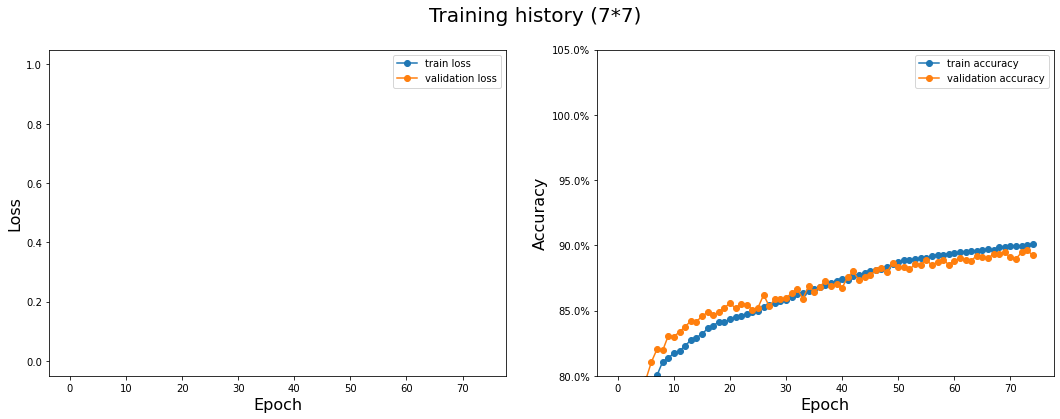

In [25]:
plot_training_history(output_7_r1,7, acc_lower = 80)

In [26]:
batch_size = 128
output_7_r4 = get_latency_mse_snn_results(resolution = 7, ratio = 4, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 85.0%, and Avg loss: 1.670419 

Final Validation Accuracy: 84.6%, and Avg loss: 3.336505 

Training time: 7.9 minutes


In [27]:
batch_size = 32
output_7_r10 = get_latency_mse_snn_results(resolution = 7, ratio = 10, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 86.6%, and Avg loss: 1.668359 

Final Validation Accuracy: 84.1%, and Avg loss: 3.431466 

Training time: 13.05 minutes


In [28]:
batch_size = 32
output_7_r100 = get_latency_mse_snn_results(resolution = 7, ratio = 100, epochs = 75, slope = 5, verbose = False)

Starting Training
Done!
Final Train Accuracy: 81.0%, and Avg loss: 2.085468 

Final Validation Accuracy: 72.9%, and Avg loss: 3.676075 

Training time: 6.63 minutes


# Saving Results

In [ ]:
output_56_r1
output_56_r4
output_56_r10
output_56_r100

output_28_r1
output_28_r4
output_28_r10
output_28_r100

output_14_r1
output_14_r4
output_14_r10
output_14_r100

output_7_r1
output_7_r4
output_7_r10
output_7_r100

In [29]:
output_res = ['output_56', 'output_28', 'output_14','output_7']
output_ratio = ['_r1','_r4','_r10','_r100']
index = ['avg_train_loss', 'train_accuracy', 'avg_valid_loss', 'valid_accuracy']

In [30]:
all_columns = []
all_models = []
for name in output_res:
    for ratio in output_ratio: 
        model_name = name + ratio
        all_models.append(model_name)
        for indice in index: 
            column_name = name + ratio + '_' + indice
            all_columns.append(column_name)

In [26]:
output_56_r1.keys()

dict_keys(['avg_train_loss', 'train_accuracy', 'avg_valid_loss', 'valid_accuracy'])

In [95]:
locals()[all_models[0]]['avg_train_loss']

[0.13006120920181274,
 0.042799513787031174,
 0.03713303059339523,
 0.06466007232666016,
 0.015814419835805893,
 0.03430761396884918,
 0.0019204705022275448,
 0.011888238601386547,
 0.0019352637464180589,
 0.008182739838957787,
 0.017129648476839066,
 0.02643691748380661,
 0.0015373200876638293,
 0.14406420290470123,
 0.000397319789044559,
 0.007249984424561262,
 0.04614896699786186,
 0.07822474092245102,
 0.0012644941452890635,
 0.0038358275778591633,
 0.00786791555583477,
 0.000664190505631268,
 0.001168444869108498,
 0.0002316593745490536,
 0.005893235560506582,
 0.0007707395707257092,
 0.0001737207785481587,
 3.402635411475785e-05,
 3.451213342486881e-05,
 5.471266194945201e-05,
 0.0008975357632152736,
 0.00015174300642684102,
 0.0006222904194146395,
 5.256674285192275e-06,
 7.913309673313051e-06,
 0.00016171134484466165,
 0.000734230678062886,
 1.4118486433289945e-05,
 0.01709653064608574,
 2.1993864720570855e-05,
 1.7628976820560638e-06,
 0.022050853818655014,
 7.068630907269835e

In [31]:
df = pd.DataFrame()
for entry in all_models:
    for key in index:
        string = entry + '_' + key
        
        df[string] = locals()[entry][key]

In [32]:
df

,output_56_r1_avg_train_loss,output_56_r1_train_accuracy,output_56_r1_avg_valid_loss,output_56_r1_valid_accuracy,output_56_r4_avg_train_loss,output_56_r4_train_accuracy,output_56_r4_avg_valid_loss,output_56_r4_valid_accuracy,output_56_r10_avg_train_loss,output_56_r10_train_accuracy,...,output_7_r4_avg_valid_loss,output_7_r4_valid_accuracy,output_7_r10_avg_train_loss,output_7_r10_train_accuracy,output_7_r10_avg_valid_loss,output_7_r10_valid_accuracy,output_7_r100_avg_train_loss,output_7_r100_train_accuracy,output_7_r100_avg_valid_loss,output_7_r100_valid_accuracy
0,1.830772,78.685000,4.611421,91.83,2.610935,40.080000,4.963690,75.45,2.378633,45.600000,...,2.764889,9.78,2.691024,9.866667,2.679641,9.88,3.992051,9.500000,3.106147,9.79
1,1.113603,92.795000,4.437547,93.66,2.200594,83.073333,5.081515,89.15,2.120453,84.833333,...,2.911398,17.76,2.057868,12.133333,2.855906,20.50,2.887917,9.000000,2.894452,9.80
2,0.930229,94.105000,4.420147,94.73,1.805089,89.513333,4.935894,90.76,1.703916,89.333333,...,3.006662,39.56,2.053483,35.466667,3.038039,46.87,2.687594,9.833333,2.750062,9.79
3,0.844409,94.956667,4.392326,95.18,1.509597,91.280000,4.745568,91.74,1.416651,90.783333,...,3.231533,45.06,2.135855,53.683333,3.173263,54.87,2.564246,10.000000,2.607872,9.78
4,0.790839,95.543333,4.320792,95.67,1.329365,92.133333,4.666785,92.23,1.252186,91.850000,...,3.271589,48.34,2.132634,58.833333,3.334400,61.20,2.472728,9.833333,2.595584,9.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.448011,99.741667,4.430603,98.05,0.526122,99.340000,4.392900,96.84,0.462169,99.733333,...,3.341161,84.49,1.672443,86.433333,3.440139,84.24,2.091174,78.833333,3.661240,71.87
71,0.446774,99.743333,4.388725,98.12,0.525142,99.353333,4.400374,96.81,0.459639,99.733333,...,3.336647,84.52,1.677120,86.633333,3.411141,84.43,2.070864,79.500000,3.619136,72.11
72,0.445493,99.750000,4.435111,98.15,0.521320,99.346667,4.408088,96.79,0.458549,99.733333,...,3.324887,84.32,1.677604,86.550000,3.437248,84.51,2.090419,79.833333,3.660859,72.84
73,0.443962,99.746667,4.440116,98.10,0.520664,99.366667,4.382348,96.77,0.457270,99.733333,...,3.327659,84.32,1.674173,86.816667,3.445701,84.33,2.092718,80.666667,3.637824,72.55


In [33]:
df.to_csv('all_simple_latency_snn_training_histories.csv')

# Plots for Latency encoding

In [7]:
train, _ = load_in_data(28, 1)

In [8]:
x,y = next(iter(train))

In [9]:
x_latency =  spikegen.latency(x, num_steps=num_steps,tau = 5, threshold=0.01, normalize=True, linear=True)

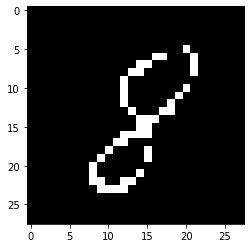

In [10]:
spike_data_sample_latency = x_latency[:, 10, -1]
spike_data_sample_latency.size()
plt.imshow(spike_data_sample_latency[0], cmap = 'gray')
plt.show()

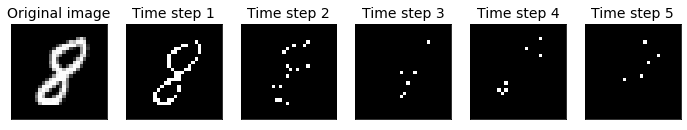

In [11]:
fig, axs = plt.subplots(1, 6, figsize=(12, 8))
axs[0].imshow(x[10,-1], cmap = 'gray')
axs[1].imshow(spike_data_sample_latency[0], cmap = 'gray')
axs[2].imshow(spike_data_sample_latency[1], cmap = 'gray')
axs[3].imshow(spike_data_sample_latency[2], cmap = 'gray')
axs[4].imshow(spike_data_sample_latency[3], cmap = 'gray')
axs[5].imshow(spike_data_sample_latency[4], cmap = 'gray')

axs[0].set_title('Original image', fontsize = 14)

for i in range(1,6):
    axs[i].set_title(f'Time step {i}', fontsize = 14)
    
for i in range(6):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.savefig('MnistImageslatency.png')
plt.show()